# 🏪 Multi-Store Retail Demand Forecasting

## 📌 Business Problem
A retail company wants to forecast daily product demand at the store level to optimize inventory planning and reduce stockouts.

## 🎯 Objective
- Compare classical time series models (ARIMA, SARIMA, SARIMAX)
- Implement a Machine Learning model (Random Forest)
- Benchmark models using RMSE
- Derive business insights from forecasting performance


## 🧩 Project Workflow
1. Data Loading & Scope Definition
2. Exploratory Data Analysis
3. Classical Time Series Modeling
4. Feature Engineering
5. Machine Learning Forecasting
6. Model Comparison & Business Insights


In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prateek6685","key":"60e9d35959e19f36c70b7dc1c3237172"}'}

In [2]:
!pip install kaggle

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [3]:
!kaggle competitions list


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd       2340           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-27 23:59:00  Research           200,000 Usd       1360           False  
https://www.kaggle.com/competitions/stanford-rna-3d-folding-2                       2026-03-25 23:59:00  Featured           100,000 Usd        936           False  
https://www.kaggle.com/competitions/med-gemma-impact-challenge                      2026-02-24 23:59:00  Featured           100,000 Usd        154           False  
https://ww

In [4]:
!kaggle competitions download -c store-sales-time-series-forecasting


  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 850MB/s]


In [5]:
!unzip store-sales-time-series-forecasting.zip


Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [6]:
!ls


holidays_events.csv  sample_submission.csv		      test.csv
oil.csv		     store-sales-time-series-forecasting.zip  train.csv
sample_data	     stores.csv				      transactions.csv


# Load **Dataset**

In [7]:
import pandas as pd

train = pd.read_csv("train.csv")

print("Shape of dataset: ", train.shape)
train.head()

Shape of dataset:  (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# Convert Date Properly

In [8]:
train['date'] = pd.to_datetime(train['date'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


# Identify Top **Stores**

In [9]:
top_stores = (
    train.groupby('store_nbr')['sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)
top_stores

,sales
store_nbr,
44,6.208755e+07
45,5.449801e+07
47,5.094831e+07


# Identify Top Product **Families**

In [10]:
top_families = (
    train.groupby('family')['sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)
top_families

,sales
family,
GROCERY I,3.434627e+08
BEVERAGES,2.169545e+08
PRODUCE,1.227047e+08


# Filter Dataset

In [11]:
filtered_data = train[
    (train['store_nbr'].isin(top_stores.index)) &
    (train['family'].isin(top_families.index))
]

print("Filtered dataset shape: ", filtered_data.shape)
filtered_data.head()

Filtered dataset shape:  (15156, 6)


,id,date,store_nbr,family,sales,onpromotion
1257,1257,2013-01-01,44,BEVERAGES,0.0,0
1266,1266,2013-01-01,44,GROCERY I,0.0,0
1284,1284,2013-01-01,44,PRODUCE,0.0,0
1290,1290,2013-01-01,45,BEVERAGES,0.0,0
1299,1299,2013-01-01,45,GROCERY I,0.0,0


# **Create Store–Product Subset**

In [12]:
target_data = filtered_data[
    (filtered_data['store_nbr'] == 44) &
    (filtered_data['family'] == 'GROCERY I')
].copy()

target_data = target_data.sort_values('date')
target_data.head()

,id,date,store_nbr,family,sales,onpromotion
1266,1266,2013-01-01,44,GROCERY I,0.0,0
3048,3048,2013-01-02,44,GROCERY I,10686.0,0
4830,4830,2013-01-03,44,GROCERY I,7342.0,0
6612,6612,2013-01-04,44,GROCERY I,7250.0,0
8394,8394,2013-01-05,44,GROCERY I,10699.0,0


# **Check Time Coverage**

In [13]:
print("Date range:", target_data['date'].min(), "to", target_data['date'].max())
print("Number of rows:", len(target_data))

Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Number of rows: 1684


# **Aggregate Daily Sales**

In [14]:
daily_sales = target_data.groupby('date')['sales'].sum().reset_index()
daily_sales.set_index('date', inplace=True)

daily_sales.head()

,sales
date,
2013-01-01,0.0
2013-01-02,10686.0
2013-01-03,7342.0
2013-01-04,7250.0
2013-01-05,10699.0


# **Plot First Time Series**

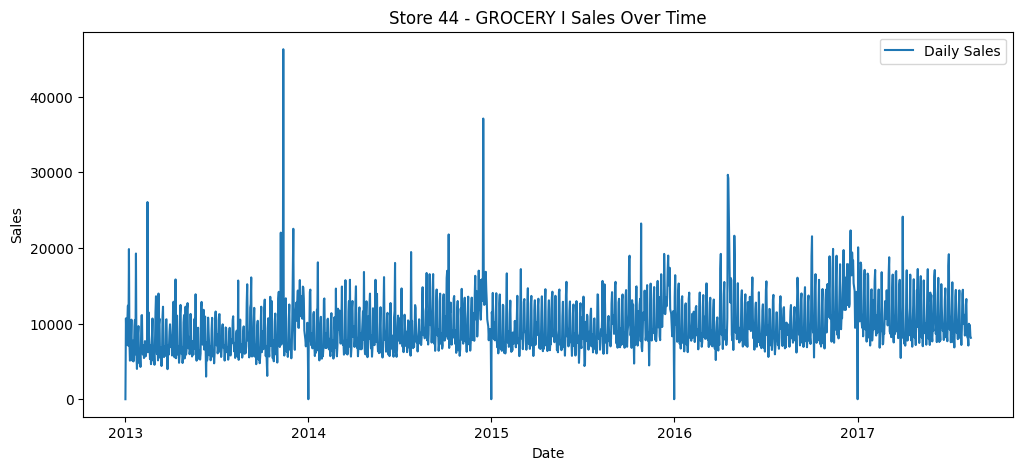

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_sales, label="Daily Sales")
plt.title("Store 44 - GROCERY I Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# **To confirm weekly seasonality**

In [16]:
daily_sales['day_of_week'] = daily_sales.index.dayofweek
daily_sales.groupby('day_of_week')['sales'].mean()


,sales
day_of_week,
0,8947.796249
1,8404.271847
2,9011.762083
3,7307.439396
4,8604.337500
5,12493.763485
6,13346.483333


In [17]:
daily_sales.describe()


,sales,day_of_week
count,1684.000000,1684.000000
mean,9730.436483,2.997031
std,3576.086090,2.001334
min,0.000000,0.000000
25%,7271.000000,1.000000
50%,8804.000000,3.000000
75%,11645.500000,5.000000
max,46271.000000,6.000000


# **This smooths the noise and makes trend clearer.**

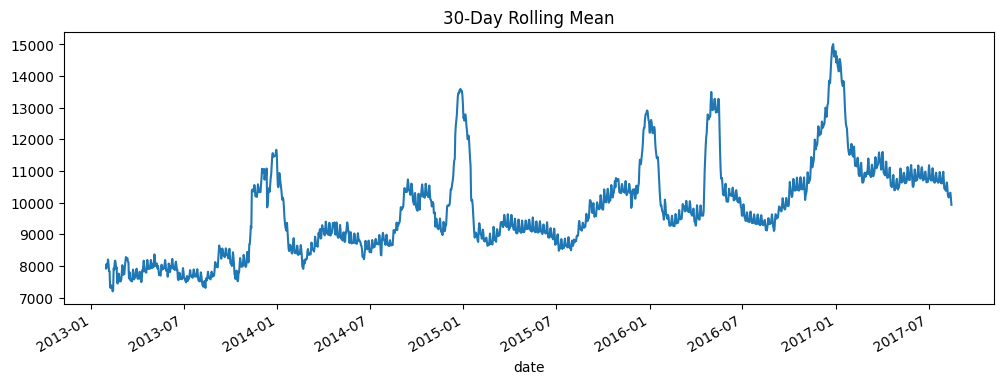

In [18]:
daily_sales['sales'].rolling(30).mean().plot(figsize=(12,4))
plt.title("30-Day Rolling Mean")
plt.show()

# **Apply log transform**

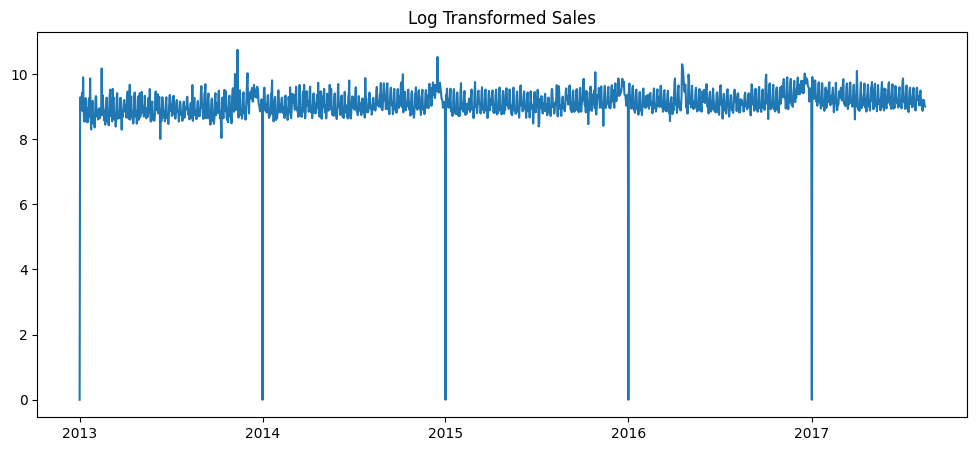

In [19]:
import numpy as np

daily_sales['log_sales'] = np.log1p(daily_sales['sales'])

plt.figure(figsize=(12,5))
plt.plot(daily_sales['log_sales'])
plt.title("Log Transformed Sales")
plt.show()

# **ADF Test (Stationarity Check)**

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_sales['log_sales'])
print("ADF statistic:", result[0])
print("p-value:", result[1])

ADF statistic: -6.462406056560421
p-value: 1.4324129745806155e-08


# **First Differencing**

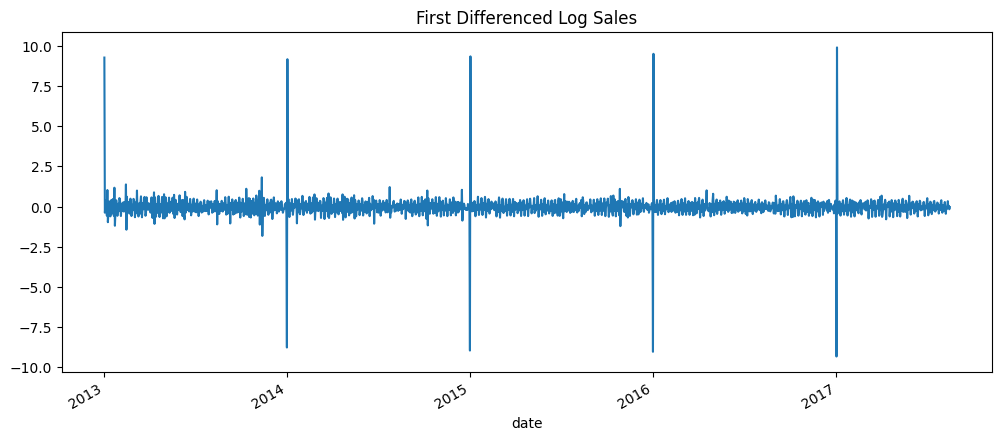

In [21]:
daily_sales['diff_log_sales'] = daily_sales['log_sales'].diff()

daily_sales['diff_log_sales'].dropna().plot(figsize=(12,5))
plt.title("First Differenced Log Sales")
plt.show()

In [22]:
result = adfuller(daily_sales['diff_log_sales'].dropna())
print("ADF statistic:", result[0])
print("p-value:", result[1])

ADF statistic: -13.651617407154424
p-value: 1.5818870748314474e-25


# **Train/Test Split**

In [23]:
train_size = int(len(daily_sales)*0.9)

train_data = daily_sales.iloc[:train_size]
test_data = daily_sales.iloc[train_size:]

print("Train_size:", len(train_data))
print("Test_size:", len(test_data))

Train_size: 1515
Test_size: 169


# **Train ARIMA on TRAIN data only**

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data['log_sales'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              log_sales   No. Observations:                 1515
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1398.141
Date:                Mon, 16 Feb 2026   AIC                           2802.282
Time:                        08:20:12   BIC                           2818.250
Sample:                             0   HQIC                          2808.228
                               - 1515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0846      0.012      7.230      0.000       0.062       0.107
ma.L1         -0.9917      0.006   -175.955      0.000      -1.003      -0.981
sigma2         0.3703      0.005     72.810      0.0

# **Forecast on Test Period**

In [25]:
forecast_log = model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# **Now convert back from log scale:**

In [26]:
forecast = np.expm1(forecast_log)

# **Compare Prediction vs Actual**

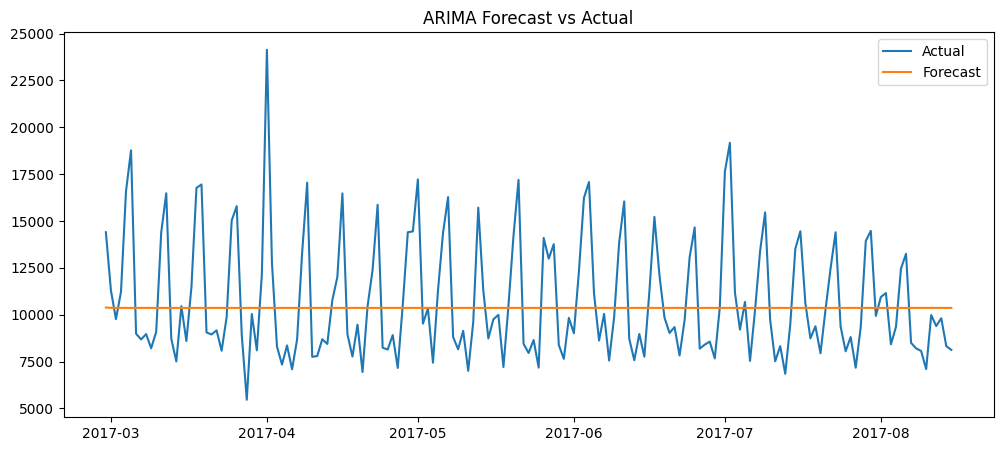

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_data.index, test_data['sales'], label="Actual")
plt.plot(test_data.index, forecast, label="Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

## **Calculate RMSE**

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_data['sales'], forecast))
print("ARIMA rmse:", rmse)

ARIMA rmse: 3212.843625478498


# **Build SARIMA Model**

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_data['log_sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)

sarima_fit = sarima_model.fit(disp=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# **Forecast**

In [30]:
forecast_log_sarima = sarima_fit.forecast(steps=len(test_data))
forecast_sarima = np.expm1(forecast_log_sarima)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## **Plot**

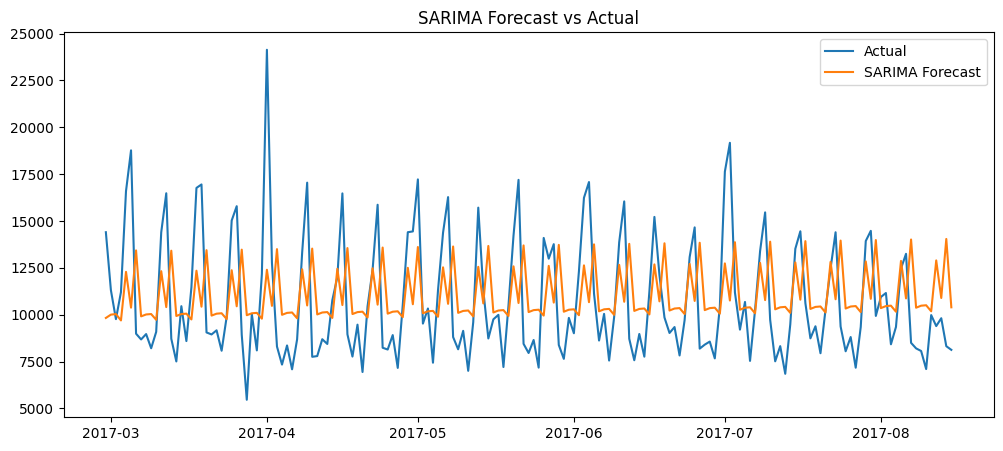

In [31]:
plt.figure(figsize=(12,5))
plt.plot(test_data.index, test_data['sales'], label='Actual')
plt.plot(test_data.index, forecast_sarima, label='SARIMA Forecast')
plt.title("SARIMA Forecast vs Actual")
plt.legend()
plt.show()

### **Calculate RMSE**

In [32]:
rsme_sarima = np.sqrt(mean_squared_error(test_data['sales'], forecast_sarima))
print("SARIMA rmse:", rsme_sarima)

SARIMA rmse: 3245.151871861065


In [33]:
filtered_data.columns



Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

# **We Move to SARIMAX with promotions as external variable**

Prepare Exogenous Variable

In [34]:
daily_sales_exog = target_data.groupby('date')[['sales','onpromotion']].sum()
daily_sales_exog = daily_sales_exog.sort_index()

daily_sales_exog.head()

,sales,onpromotion
date,,
2013-01-01,0.0,0
2013-01-02,10686.0,0
2013-01-03,7342.0,0
2013-01-04,7250.0,0
2013-01-05,10699.0,0


# **Now log transform only sales:**

In [35]:
daily_sales_exog['log_sales'] = np.log1p(daily_sales_exog['sales'])


# **Train/Test Split (With Exog)**

In [36]:
train_size = int(len(daily_sales_exog)*0.9)

train_exog = daily_sales_exog.iloc[:train_size]
test_exog = daily_sales_exog.iloc[train_size:]


# **Build SARIMAX Model**

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train_exog['log_sales'],
    exog = train_exog[['onpromotion']],
    order = (1,1,1),
    seasonal_order = (1,1,1,7)
)

sarimax_fit = sarimax_model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### **Forecast with Promotion Variable**

In [38]:
forecast_log_sarimax = sarimax_fit.forecast(
    steps=len(test_exog),
    exog=test_exog[['onpromotion']]
)

forecast_sarimax = np.expm1(forecast_log_sarimax)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# **Plot Results**

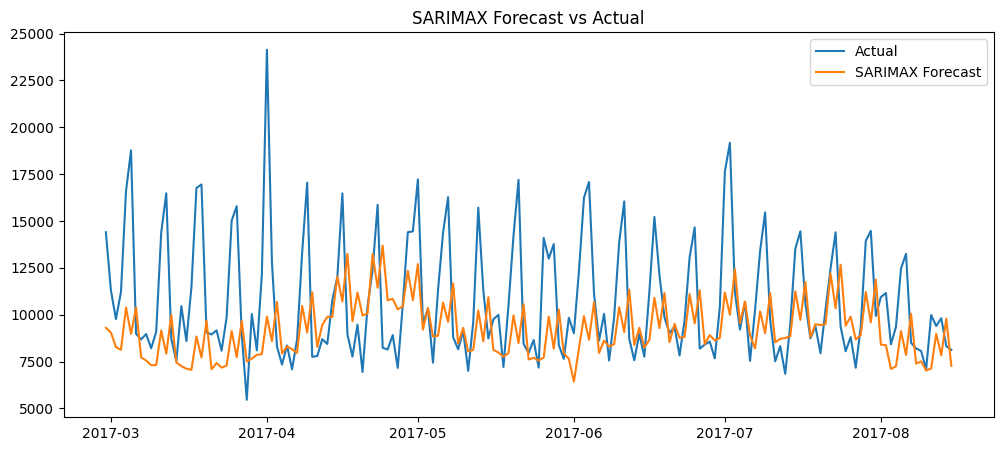

In [39]:
plt.figure(figsize=(12,5))
plt.plot(test_exog.index, test_exog['sales'], label='Actual')
plt.plot(test_exog.index, forecast_sarimax, label="SARIMAX Forecast")
plt.title("SARIMAX Forecast vs Actual")
plt.legend()
plt.show()

Calculate RMSE

In [40]:
rmse_sarimax = np.sqrt(mean_squared_error(test_exog['sales'], forecast_sarimax))
print("SARIMAX rmse:", rmse_sarimax)

SARIMAX rmse: 3512.6881012475146


MACHINE LEARNING FORECASTING LAYER

We’ll build a Random Forest forecasting model with engineered features.

In [51]:
ml_data = daily_sales_exog.copy()

#lag features
ml_data['lag_1'] = ml_data['sales'].shift(1)
ml_data['lag_7'] = ml_data['sales'].shift(7)
ml_data['lag_14'] = ml_data['sales'].shift(14)

#rolling mean
ml_data['rolling_mean_7'] = ml_data['sales'].rolling(7).mean()

# Day of week
ml_data['day_of_week'] = ml_data.index.dayofweek

#Drop Nan row
ml_data.dropna()

,sales,onpromotion,log_sales,lag_1,lag_7,lag_14,rolling_mean_7,day_of_week
date,,,,,,,,
2013-01-15,5096.0,0,8.536407,5756.0,19849.0,0.0,6900.857143,1
2013-01-16,7737.0,0,8.953899,5096.0,7546.0,10686.0,6928.142857,2
2013-01-17,4998.0,0,8.516993,7737.0,5101.0,7342.0,6913.428571,3
2013-01-18,6000.0,0,8.699681,4998.0,5993.0,7250.0,6914.428571,4
2013-01-19,9628.0,0,9.172535,6000.0,8294.0,10699.0,7105.000000,5
...,...,...,...,...,...,...,...,...
2017-08-11,9979.0,38,9.208338,7097.0,9346.0,9344.0,9649.571429,4
2017-08-12,9391.0,39,9.147614,9979.0,12463.0,13931.0,9210.714286,5
2017-08-13,9811.0,41,9.191361,9391.0,13248.0,14472.0,8719.714286,6


In [52]:
#Train/Test Split

train_size = int(len(ml_data)* 0.9)

train_ml = ml_data.iloc[:train_size]
test_ml = ml_data.iloc[train_size:]

# **Define Features and Target**

In [56]:
features = [
    'lag_1',
    'lag_7',
    'lag_14',
    'rolling_mean_7',
    'onpromotion',
    'day_of_week'
]

X_train = train_ml[features]
y_train = train_ml['sales']

X_test = test_ml[features]
y_test = test_ml['sales']


Train Random Forest

In [58]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

Predict & Evaluate

In [59]:
rf_predictions = rf_model.predict(X_test)

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
print("Random Forest RMSE:", rmse_rf )

Random Forest RMSE: 1700.6823067496862


# **Comparison Table**

In [61]:
import pandas as pd

comparison = pd.DataFrame({
    "Model":["ARIMA", "SARIMA", "SARIMAX", "RANDOM FOREST"],
    "RMSE": [3212, 3245, 3512, rmse_rf]
})

comparison

,Model,RMSE
0,ARIMA,3212.000000
1,SARIMA,3245.000000
2,SARIMAX,3512.000000
3,RANDOM FOREST,1700.682307


# Classical time series models captured overall trends but struggled with nonlinear demand spikes.
# After incorporating lag-based features and calendar effects, the Random Forest model significantly reduced forecasting error

# **Feature Importance**

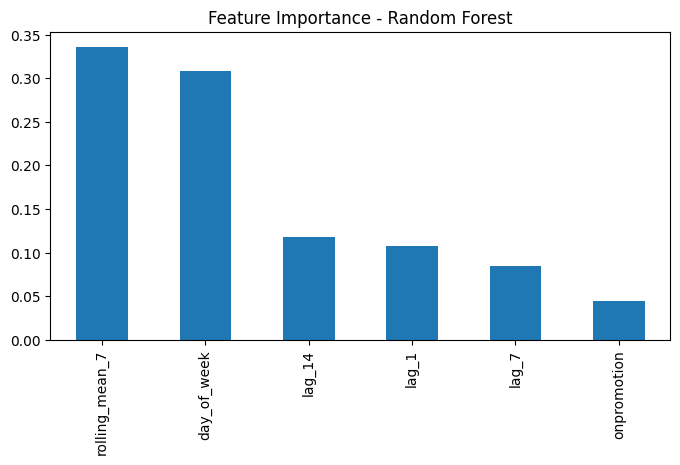

,0
rolling_mean_7,0.336248
day_of_week,0.308008
lag_14,0.118119
lag_1,0.107448
lag_7,0.085102
onpromotion,0.045075


In [63]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=features
).sort_values(ascending=False)

feature_importance.plot(kind='bar', figsize=(8,4))
plt.title("Feature Importance - Random Forest")
plt.show()

feature_importance

# If lag_1 is highest:

Recent sales are the strongest predictor of tomorrow’s demand.

# If lag_7 is high:

Weekly seasonality strongly influences sales.

# If onpromotion is meaningful:

Promotional activity has measurable impact on demand.

🔹 Key Findings

*  Weekly seasonality strongly affects grocery demand.

*   Recent sales trends are powerful predictors.

*  Classical ARIMA models underperform compared to ML-based models.

*   Promotions have moderate impact for this store-product combination.


## ✅ Final Conclusion
Classical time series models captured overall trends but struggled with nonlinear retail demand spikes.

After feature engineering (lag features, rolling averages, calendar effects) and implementing a Random Forest model, forecasting error was significantly reduced.

This demonstrates that hybrid forecasting approaches combining statistical modeling and machine learning provide stronger performance for retail demand prediction.

---
📈 **Key Takeaway:** Feature engineering and model benchmarking are critical for building production-ready forecasting systems.
